In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, ConfusionMatrixDisplay

In [2]:
titanic = pd.read_csv('titanic_dataset.csv')
titanic.index = titanic['PassengerId']
#titanic = titanic.replace(['male', 'female'],[0,1])
#titanic = titanic.replace(['S', 'Q', 'C'],[1,2,3])
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,,
1,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#  1. Use the titanic data set, perform preprocessing by deal with missing values, drop irrelevant attributes.

In [3]:
titanic.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [4]:
#replacing missing values in 'Age' by its median
titanic['Age'] = titanic['Age'].fillna(titanic.Age.median())
titanic['Embarked'] = titanic['Embarked'].fillna(titanic.Embarked.mode()[0])

In [5]:
#dropped 'Ticket', 'Fare' ,' Cabin', 'Name' attributes due to their irrelevancy
titanic = titanic.drop(labels=['Ticket', 'Fare', 'Cabin', 'PassengerId', 'Name'], axis=1)

# 2. Use the scikit learn pipelines to perform the preprocessing - standardizing, encoding and model fitting in one step.

In [6]:
X = titanic.drop(columns='Survived', axis=1)
y = titanic['Survived']
X_train, X_test, y_train, y_test = train_test_split(titanic, y, test_size = 0.20)

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

numeric_features = titanic.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features),
                                               ('cat', categorical_transformer, categorical_features)])

gnb = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', GaussianNB())])
gnb.fit(X_train, y_train)

#pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])
#pipe.fit(X_train, y_train)
#print(pipe.score(X_test, y_test))

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Survived', 'Pclass', 'Age', 'SibSp', 'Parch'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Sex', 'Embarked'], dtype='object'))])),
                ('classifier', GaussianNB())])

In [7]:
y_pred = gnb.predict(X_test)
accuracy_score(y_test, y_pred)

1.0

# 3. Perform Bayes classification using cross validation.

In [8]:
crossval = cross_val_score(gnb, X_train, y_train, cv=10)
print(crossval)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


# 4. Tabulate using relevant measures of accuracy , Sensitivity and specificity.


<Figure size 720x360 with 0 Axes>

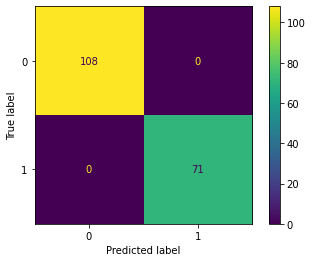

In [9]:
cf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cf_matrix.ravel()

plt.figure(figsize=(10,5))
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=gnb.classes_)
disp.plot()
plt.show()

# 5. Visualize the ROC curve and comment on performance

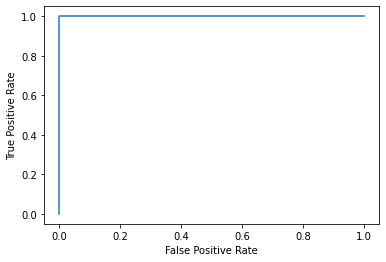

In [10]:
y_pred_proba = gnb.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)

plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()